# Final Project Demertzoglou Efstratios

## Importing the necessary libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurolab as nl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import mode


## Importing the BankNote dataset

In [60]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
banknote_authentication = fetch_ucirepo(id=267) 
  
# data (as pandas dataframes) 
X = banknote_authentication.data.features 
y = banknote_authentication.data.targets 

# Combine X and y for easier preprocessing
df = pd.concat([X, y.squeeze().rename("target")], axis=1)

# Creating a copy for 'before' and 'after' comparisons
df_before = df.copy()

# metadata 
print(banknote_authentication.metadata) 
  
# variable information 
print(banknote_authentication.variables) 


{'uci_id': 267, 'name': 'Banknote Authentication', 'repository_url': 'https://archive.ics.uci.edu/dataset/267/banknote+authentication', 'data_url': 'https://archive.ics.uci.edu/static/public/267/data.csv', 'abstract': 'Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1372, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C55P57', 'creators': ['Volker Lohweg'], 'intro_paper': None, 'additional_info': {'summary': 'Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final im

## Step 2: Check for Outliers and Missing Values


In [61]:
# Step 2: Check for Outliers and Missing Values
# Outlier Detection & Removal using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to all numeric columns (excluding the target column)
for col in df.select_dtypes(include=np.number).columns[:-1]:
    df = remove_outliers(df, col)

# Check for Missing Values
if df.isnull().sum().any():
    # Replace missing values with the mean of their respective column
    df.fillna(df.mean(), inplace=True)

# Creating a copy for 'after' comparisons
df_after = df.copy()




### Showing before and after outlier and missing values removal

/tmp/ipykernel_16590/286926772.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(df_before.iloc[:, :-1].values, labels=df_before.columns[:-1])
/tmp/ipykernel_16590/286926772.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(df_after.iloc[:, :-1].values, labels=df_after.columns[:-1])


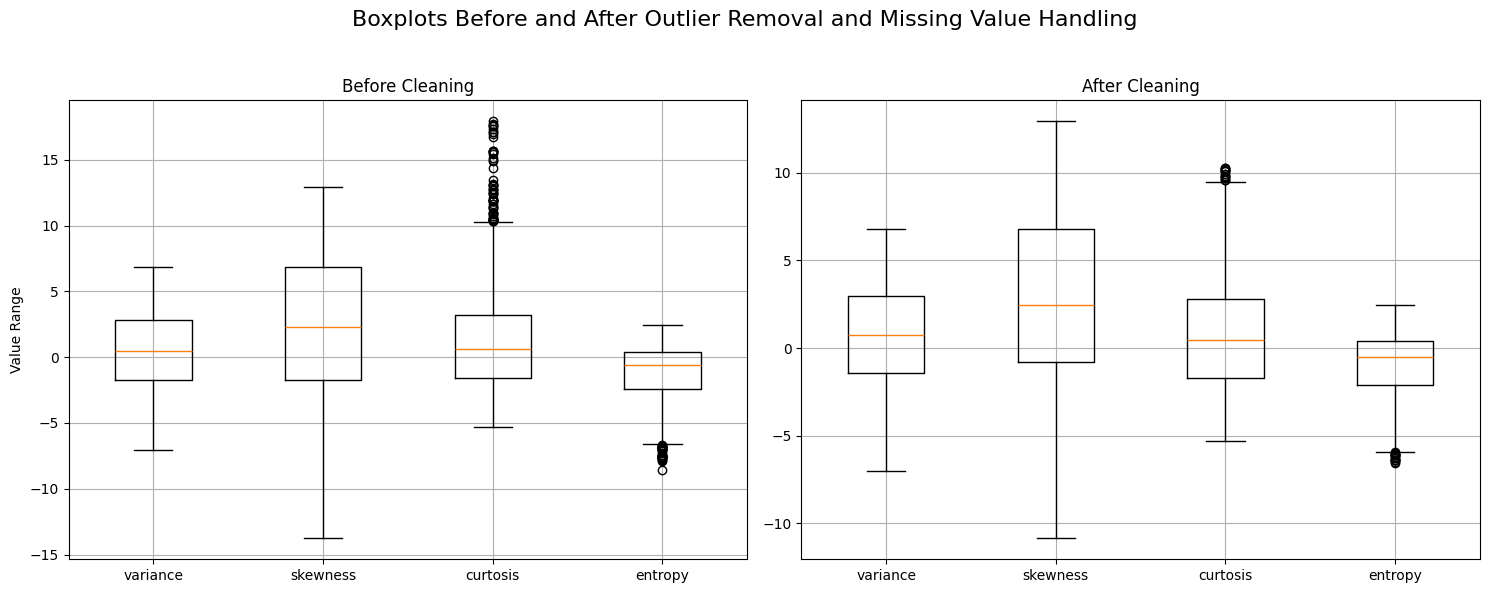

In [62]:
# Visualize Before and After with Boxplots
# Subplots for Before and After
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Boxplots Before and After Outlier Removal and Missing Value Handling", fontsize=16)

# Boxplot Before
axs[0].boxplot(df_before.iloc[:, :-1].values, labels=df_before.columns[:-1])
axs[0].set_title("Before Cleaning")
axs[0].set_ylabel("Value Range")
axs[0].grid(True)

# Boxplot After
axs[1].boxplot(df_after.iloc[:, :-1].values, labels=df_after.columns[:-1])
axs[1].set_title("After Cleaning")
axs[1].grid(True)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()

## Step 3: Data Preprocessing

### Normalizing data using MinMaxScaler

In [63]:
# Normalize features to [0, 1]
X = MinMaxScaler().fit_transform(X)

### Split Dataset into training and test set (70-30)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 960 samples
Test set size: 412 samples


## KMeans to find optimal number of clusters

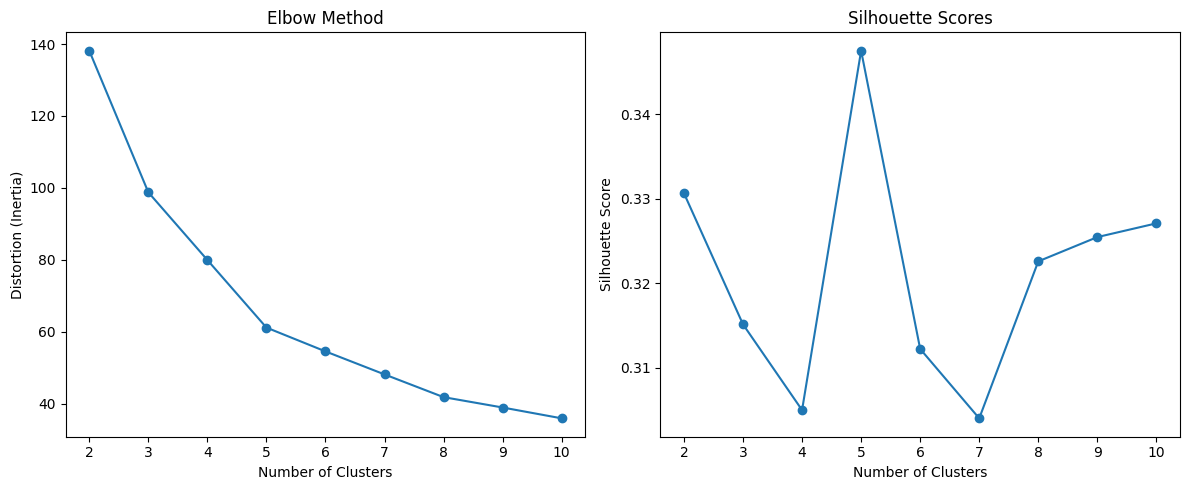

Optimal number of clusters based on silhouette score: 5


In [65]:
# Step 1: Elbow Method to Determine Optimal Number of Categories
def elbow_method(X, max_clusters=10):
    distortions = []
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Plot Elbow and Silhouette Score
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Distortion (Inertia)")

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title("Silhouette Scores")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()

    # Return the optimal number of clusters (based on the Elbow Method or Silhouette Score)
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")
    return optimal_clusters


# Determine the number of categories using the Elbow Method
optimal_categories = elbow_method(X, max_clusters=10)

## NN training 

In [77]:
# Step 2: Create and Train the Neural Network
# Using the optimal number of categories from the Elbow Method
net = nl.net.newc(nl.tool.minmax(X_train), optimal_categories)

# Configure the training parameters
net.trainf = nl.train.train_wta  # Winner-Takes-All training function
error = net.train(X, epochs=3000, show=100, goal=1e-5, lr=0.3)

Epoch: 100; Error: 557.6492806737257;
Epoch: 200; Error: 557.6492806737257;
Epoch: 300; Error: 557.6492806737257;
Epoch: 400; Error: 557.6492806737257;
Epoch: 500; Error: 557.6492806737257;
Epoch: 600; Error: 557.6492806737257;
Epoch: 700; Error: 557.6492806737257;
Epoch: 800; Error: 557.6492806737257;
Epoch: 900; Error: 557.6492806737257;
Epoch: 1000; Error: 557.6492806737257;
Epoch: 1100; Error: 557.6492806737257;
Epoch: 1200; Error: 557.6492806737257;
Epoch: 1300; Error: 557.6492806737257;
Epoch: 1400; Error: 557.6492806737257;
Epoch: 1500; Error: 557.6492806737257;
Epoch: 1600; Error: 557.6492806737257;
Epoch: 1700; Error: 557.6492806737257;
Epoch: 1800; Error: 557.6492806737257;
Epoch: 1900; Error: 557.6492806737257;
Epoch: 2000; Error: 557.6492806737257;
Epoch: 2100; Error: 557.6492806737257;
Epoch: 2200; Error: 557.6492806737257;
Epoch: 2300; Error: 557.6492806737257;
Epoch: 2400; Error: 557.6492806737257;
Epoch: 2500; Error: 557.6492806737257;
Epoch: 2600; Error: 557.6492806737

## Plotting Training Results

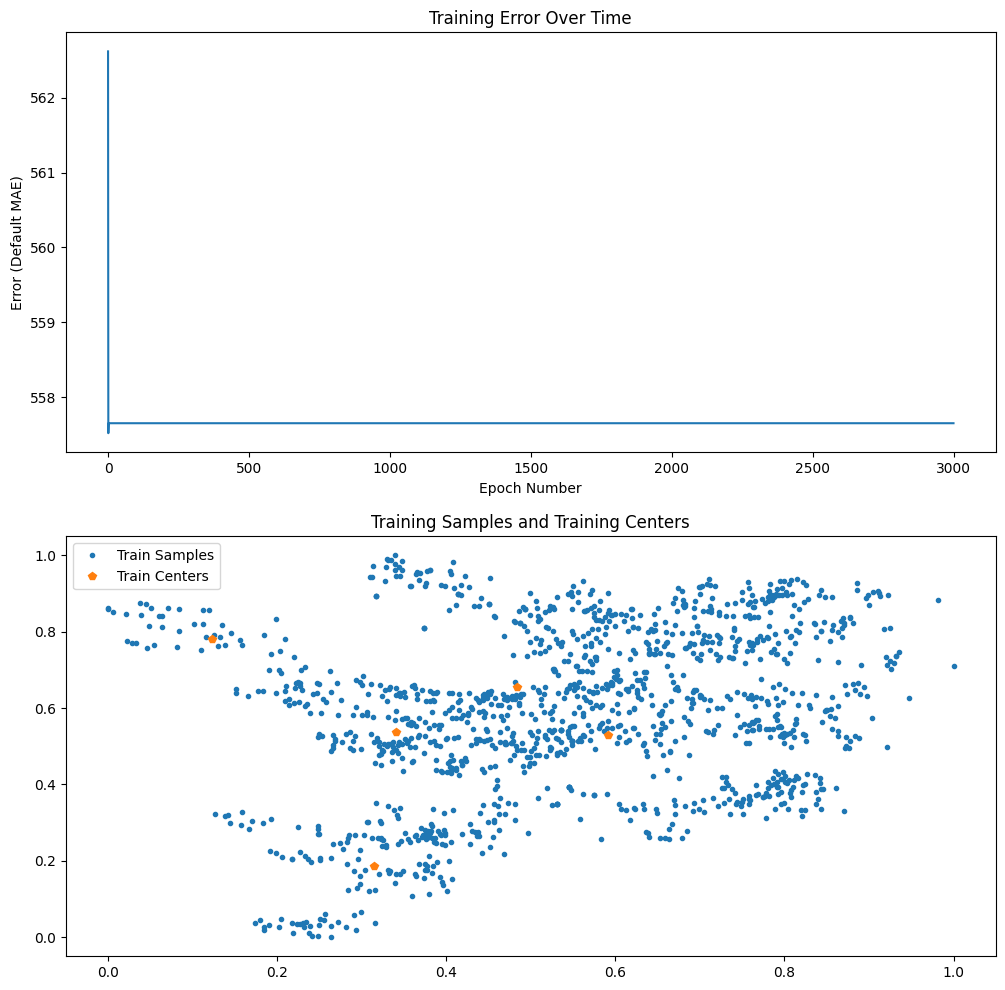

In [78]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(error)
plt.title("Training Error Over Time")
plt.xlabel("Epoch Number")
plt.ylabel("Error (Default MAE)")

# Visualize the clusters and training centers
w = net.layers[0].np['w']
plt.subplot(2, 1, 2)
plt.plot(X[:, 0], X[:, 1], '.', w[:, 0], w[:, 1], 'p')
plt.title("Training Samples and Training Centers")
plt.legend(['Train Samples', 'Train Centers'])
plt.show()

## Presenting to the NN the test set

In [80]:
# Step 5: Present Test Set to Neural Network
y_pred = net.sim(X_test)  # Predict on test set
y_pred_binary = np.argmax(y_pred, axis=1)  # Select the index of the max value for each prediction
y_test_array = y_test.squeeze().values if isinstance(y_test, pd.DataFrame) else y_test


## Mapping Clusters to True Classes

In [87]:
# Step 1: Map Clusters to True Classes
# Map predicted clusters to actual classes based on the majority class in each cluster

def map_clusters_to_classes(y_train, y_train_clusters):
    cluster_to_class_mapping = {}
    unique_clusters = np.unique(y_train_clusters)
    for cluster in unique_clusters:
        # Find the most frequent actual class within each cluster
        majority_class = mode(y_train[y_train_clusters == cluster]).mode[0]
        cluster_to_class_mapping[cluster] = majority_class
    return cluster_to_class_mapping

# Get predicted clusters for the training set
y_train_clusters = np.argmax(net.sim(X_train), axis=1)

# Create the mapping from clusters to true classes
cluster_to_class_mapping = map_clusters_to_classes(y_train, y_train_clusters)

# Step 2: Apply Mapping to Predictions
# Get predicted clusters for the test set
y_test_clusters = np.argmax(net.sim(X_test), axis=1)

# Map predicted clusters to actual classes
y_pred_mapped = np.array([cluster_to_class_mapping[cluster] for cluster in y_test_clusters])

## Calculating Accuracy

In [88]:
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.24%


## Plotting Classified Patterns

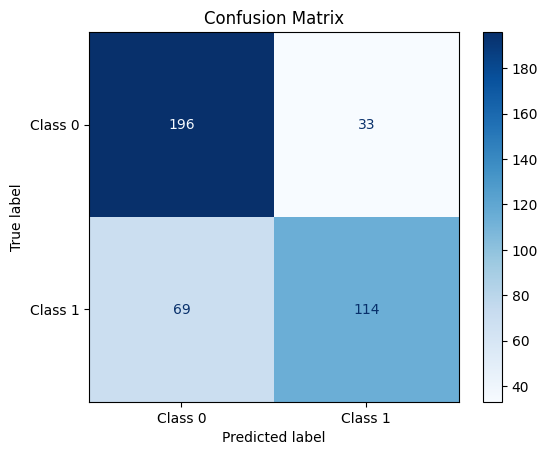

In [89]:
cm = confusion_matrix(y_test, y_pred_mapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Optimize 

In [91]:
# Optimization configurations
neuron_configs = [5, 10, 15]  # Number of neurons in the hidden layer
layer_configs = [1, 2]  # Number of layers
learning_rates = [0.1, 0.2, 0.3]  # Learning rates
epoch_configs = [1000, 2000, 3000]  # Number of epochs

# Store results
optimization_results = []

# Optimization loop
for num_layers in layer_configs:
    for num_neurons in neuron_configs:
        for lr in learning_rates:
            for epochs in epoch_configs:
                print(f"\n=== Training NN: {num_layers} Layers, {num_neurons} Neurons, LR={lr}, Epochs={epochs} ===")
                
                # Define architecture
                layer_structure = [num_neurons] * num_layers + [1]  # Add output layer
                net = nl.net.newff(nl.tool.minmax(X_train), layer_structure)
                
                # Configure training parameters
                net.trainf = nl.train.train_gd  # Gradient Descent training function
                error = net.train(X_train, y_train.to_numpy().reshape(-1, 1), epochs=epochs, show=100, goal=1e-5, lr=lr)
                
                # Predict on the test set
                y_pred = net.sim(X_test).ravel()
                y_pred_binary = (y_pred > 0.5).astype(int)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred_binary)
                print(f"Test Accuracy: {accuracy * 100:.2f}%")
                
                # Store results
                optimization_results.append({
                    "Layers": num_layers,
                    "Neurons": num_neurons,
                    "Learning Rate": lr,
                    "Epochs": epochs,
                    "Test Accuracy (%)": round(accuracy * 100, 2)
                })

# Display results in a table
results_df = pd.DataFrame(optimization_results)
print("\n=== Optimization Results Table ===")
print(results_df)

# Save results to a CSV file
results_df.to_csv("nn_optimization_results.csv", index=False)


=== Training NN: 1 Layers, 5 Neurons, LR=0.1, Epochs=1000 ===
Epoch: 100; Error: 266.5;
Epoch: 200; Error: 266.5;
Epoch: 300; Error: 266.5;
Epoch: 400; Error: 266.5;
Epoch: 500; Error: 266.5;
Epoch: 600; Error: 266.5;
Epoch: 700; Error: 266.5;
Epoch: 800; Error: 266.5;
Epoch: 900; Error: 266.5;
Epoch: 1000; Error: 266.5;
The maximum number of train epochs is reached
Test Accuracy: 44.42%

=== Training NN: 1 Layers, 5 Neurons, LR=0.1, Epochs=2000 ===
Epoch: 100; Error: 1120.5;
Epoch: 200; Error: 1120.5;
Epoch: 300; Error: 1120.5;
Epoch: 400; Error: 1120.5;
Epoch: 500; Error: 1120.5;
Epoch: 600; Error: 1120.5;
Epoch: 700; Error: 1120.5;
Epoch: 800; Error: 1120.5;
Epoch: 900; Error: 1120.5;
Epoch: 1000; Error: 1120.5;
Epoch: 1100; Error: 1120.5;
Epoch: 1200; Error: 1120.5;
Epoch: 1300; Error: 1120.5;
Epoch: 1400; Error: 1120.5;
Epoch: 1500; Error: 1120.5;
Epoch: 1600; Error: 1120.5;
Epoch: 1700; Error: 1120.5;
Epoch: 1800; Error: 1120.5;
Epoch: 1900; Error: 1120.5;
Epoch: 2000; Error: 11

In [ ]:
# Optimization configurations
neuron_configs = [10, 15]  # Number of neurons in the hidden layer
layer_configs = [2, 3]  # Number of layers
learning_rates = [0.01, 0.2]  # Learning rates
epoch_configs = [1000, 5000]  # Number of epochs

# Store results
optimization_results_v2 = []

# Optimization loop
for num_layers in layer_configs:
    for num_neurons in neuron_configs:
        for lr in learning_rates:
            for epochs in epoch_configs:
                print(f"\n=== Training NN: {num_layers} Layers, {num_neurons} Neurons, LR={lr}, Epochs={epochs} ===")
                
                # Define architecture
                layer_structure = [num_neurons] * num_layers + [1]  # Add output layer
                net = nl.net.newff(nl.tool.minmax(X_train), layer_structure)
                
                # Configure training parameters
                net.trainf = nl.train.train_gd  # Gradient Descent training function
                error = net.train(X_train, y_train.to_numpy().reshape(-1, 1), epochs=epochs, show=250, goal=1e-5, lr=lr)
                
                # Predict on the test set
                y_pred = net.sim(X_test).ravel()
                y_pred_binary = (y_pred > 0.5).astype(int)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred_binary)
                print(f"Test Accuracy: {accuracy * 100:.2f}%")
                
                # Store results
                optimization_results_v2.append({
                    "Layers": num_layers,
                    "Neurons": num_neurons,
                    "Learning Rate": lr,
                    "Epochs": epochs,
                    "Test Accuracy (%)": round(accuracy * 100, 2)
                })

# Display results in a table
results_df_v2 = pd.DataFrame(optimization_results_v2)
print("\n=== Optimization Results Table ===")
print(results_df_v2)

# Save results to a CSV file
results_df.to_csv("nn_optimization_results_v2.csv", index=False)